In [1]:
# Owen Wichiencharoen's standard Python Imports:

import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')

import matplotlib.pyplot as plt
import matplotlib.cm as cm
# plt.style.use('ggplot')
# from pylab import rcParams
%matplotlib inline

### REGRESSION PACKAGES
# from scipy import stats
# import statsmodels.formula.api as smf
# import statsmodels.api as sm
# import sklearn.linear_model as lm

### DATASET PACKAGES
from sklearn.cross_validation import KFold # train_test_split, cross_val_score
# from sklearn import datasets, metrics
from sklearn.metrics import log_loss # mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder

### TREE/RANDOMFOREST PACKAGES
# from sklearn.tree import DecisionTreeClassifier, export_graphviz
# from sklearn.ensemble import RandomForestClassifier
# import pydot
# from os import system
# from sklearn.externals.six import StringIO

### TIME SERIES PACKAGES
# from statsmodels.tsa.arima_model import ARMA, ARIMA
# from pandas.tools.plotting import autocorrelation_plot
# from statsmodels.graphics.tsaplots import plot_acf

### NLP PACKAGES
# from __future__ import unicode_literals
# import codecs # Python Codec Registry, API and helpers
# import spacy
# from spacy.en import English
# nlp_toolkit = English() # Initializing NLP
# import gensim
# from gensim.models.word2vec import Word2Vec
# from sklearn.feature_extraction.text import CountVectorizer
# from gensim.models.ldamodel import LdaModel
# from gensim.matutils import Sparse2Corpus

### OTHER PACKAGES
# import itertools
# import pandas_datareader.data as pdweb
# from pandas_datareader.data import DataReader
# from datetime import datetime
# from io import StringIO
# from pandas.io import sql
# import sqlite3
from IPython.display import Image
from mpl_toolkits.basemap import Basemap

## Important notes from Kaggle

https://www.kaggle.com/c/talkingdata-mobile-user-demographics/forums

- not all events have location (latitude/longitude), and you can treat (0,0),(1,0),(0,1),(1,1) lat/long as NaN.
- Some device_ids have duplicates (mappable to two brands/models) - the user probably upgraded his or her phone.
- ...

## Data Descriptions

- gender_age_train.csv, gender_age_test.csv - the training and test set group: this is the target variable you are going to predict
- events.csv, app_events.csv - when a user uses TalkingData SDK, the event gets logged in this data. Each event has an event id, location (lat/long), and the event corresponds to a list of apps in app_events. timestamp: when the user is using an app with TalkingData SDK
- app_labels.csv - apps and their labels, the label_id's can be used to join with label_categories
- label_categories.csv - apps' labels and their categories in text
- phone_brand_device_model.csv - device ids, brand, and models

In [2]:
Image(url='http://i.imgsafe.org/132c9be39b.png') 

In [3]:
raw_events = pd.read_csv('../../kaggle_data/events.csv', dtype={'device_id': np.str})

In [4]:
raw_label_categories = pd.read_csv('../../kaggle_data/label_categories.csv')
raw_phone_brand_device_model = pd.read_csv('../../kaggle_data/phone_brand_device_model.csv',encoding='utf-8')
raw_gender_age_train = pd.read_csv('../../kaggle_data/gender_age_train.csv', dtype={'device_id': np.str})
raw_gender_age_test = pd.read_csv('../../kaggle_data/gender_age_test.csv', dtype={'device_id': np.str})
raw_app_events = pd.read_csv('../../kaggle_data/app_events.csv', dtype={'is_installed':np.int,'is_active':np.int})
raw_app_labels = pd.read_csv('../../kaggle_data/app_labels.csv')

#### EVENTS TABLE (main)

In [5]:
print('NUMBER OF ROWS:', raw_events.shape[0])

print('\nNULL VALUES:')
print(raw_events.isnull().sum())

print("\nUNIQUE VALUES:")
for c in raw_events.columns:
    print('{}: {}'.format(c, raw_events[c].nunique()))

raw_events.head(3)

NUMBER OF ROWS: 3252950

NULL VALUES:
event_id     0
device_id    0
timestamp    0
longitude    0
latitude     0
dtype: int64

UNIQUE VALUES:
event_id: 3252950
device_id: 60865
timestamp: 588125
longitude: 3588
latitude: 3086


,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70


Umm, there're only 3000+ unique long/lats?  That's 0.1% of all events.

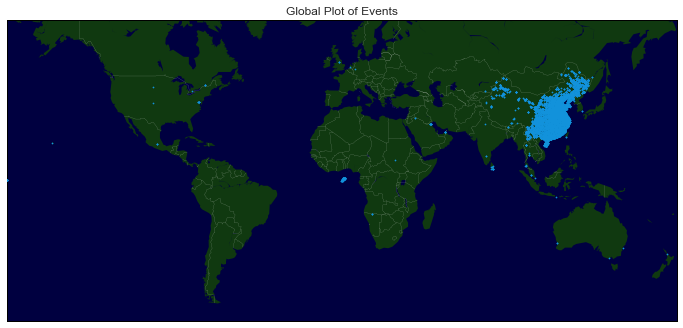

In [6]:
# GLOBAL PLOT of EVENTS
df_events_sample = raw_events.sample(n=100000)
plt.figure(1, figsize=(12,6))

# Mercator of World
m1 = Basemap(projection='merc',
             llcrnrlat=-60,
             urcrnrlat=65,
             llcrnrlon=-180,
             urcrnrlon=180,
             lat_ts=0,
             resolution='c')
m1.fillcontinents(color='#103910',lake_color='#000040')
m1.drawmapboundary(fill_color='#000040')
m1.drawcountries(linewidth=0.1, color="w")

# Plot the data
mxy = m1(df_events_sample["longitude"].tolist(), df_events_sample["latitude"].tolist())
m1.scatter(mxy[0], mxy[1], s=3, c="#1292db", lw=0, alpha=1, zorder=5)

plt.title("Global Plot of Events")
plt.show()

In [7]:
events_at0 = raw_events[(raw_events["longitude"]==0) & (raw_events["latitude"]==0)]
events_near0 = raw_events[(raw_events["longitude"]>-1) &\
                     (raw_events["longitude"]<1) &\
                     (raw_events["latitude"]>-1) &\
                     (raw_events["latitude"]<1)]
print("# events:", len(raw_events))
print("# at (0,0)", len(events_at0))
print("# near (0,0)", len(events_near0))

# events: 3252950
# at (0,0) 968675
# near (0,0) 969871


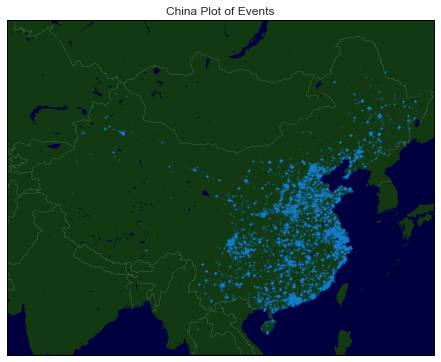

In [8]:
# CHINA PLOT of EVENTS

long_min, long_max = 70, 135
lat_min, lat_max = 15, 55
china_plotframe = (raw_events["longitude"]>long_min) &\
            (raw_events["longitude"]<long_max) &\
            (raw_events["latitude"]>lat_min) &\
            (raw_events["latitude"]<lat_max)
df_events_china = raw_events[china_plotframe].sample(n=100000)

plt.figure(2, figsize=(12,6))

# Mercator of China
m2 = Basemap(projection='merc',
             llcrnrlat=lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=long_min,
             urcrnrlon=long_max,
             lat_ts=35,
             resolution='i')
m2.fillcontinents(color='#123912',lake_color='#000040')
m2.drawmapboundary(fill_color='#000040')
m2.drawcountries(linewidth=0.1, color="w")

# Plot the data
mxy = m2(df_events_china["longitude"].tolist(), df_events_china["latitude"].tolist())
m2.scatter(mxy[0], mxy[1], s=5, c="#1292db", lw=0, alpha=0.05, zorder=5)

plt.title("China Plot of Events")
plt.show()

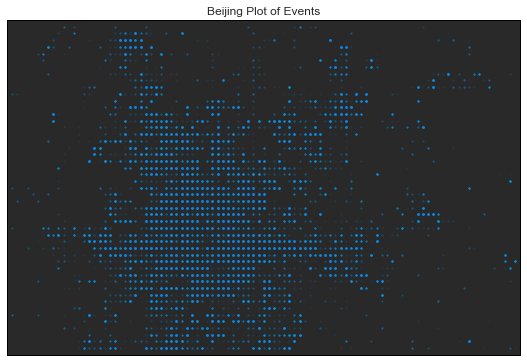

In [26]:
# BEIJING PLOT of EVENTS

long_min, long_max = 116, 117
lat_min, lat_max = 39.75, 40.25
beijing_frame = (raw_events["longitude"]>long_min) &\
              (raw_events["longitude"]<long_max) &\
              (raw_events["latitude"]>lat_min) &\
              (raw_events["latitude"]<lat_max)
df_events_beijing = raw_events[beijing_frame]
plt.figure(3, figsize=(12,6))

# Mercator of Beijing
m3 = Basemap(projection='merc',
             llcrnrlat=lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=long_min,
             urcrnrlon=long_max,
             lat_ts=35,
             resolution='c')
m3.fillcontinents(color='#292929',lake_color='#000040')
m3.drawmapboundary(fill_color='#000040')
m3.drawcountries(linewidth=0.1, color="w")

# Plot the data
mxy = m3(df_events_beijing["longitude"].tolist(), df_events_beijing["latitude"].tolist())
m3.scatter(mxy[0], mxy[1], s=5, c="#1292db", lw=0, alpha=0.1, zorder=5)

plt.title("Beijing Plot of Events")
plt.show()

In [16]:
# NOW PLOT BEIJING BY GENDER

df_train = pd.merge(raw_gender_age_train, df_events_beijing, on="device_id", how="inner")

df_m = df_train[df_train["gender"]=="M"]
df_f = df_train[df_train["gender"]=="F"]
print("# Male obs:", len(df_m))
print("# Female obs:", len(df_f))

# Male obs: 29948
# Female obs: 13630


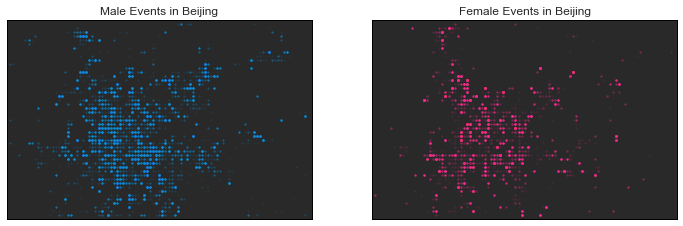

In [25]:
# BEIJING PLOT of EVENTS (BY GENDER)
plt.figure(4, figsize=(12,6))

plt.subplot(121)
m4a = Basemap(projection='merc',
             llcrnrlat=lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=long_min,
             urcrnrlon=long_max,
             lat_ts=35,
             resolution='c')
m4a.fillcontinents(color='#292929',lake_color='#000040')
m4a.drawmapboundary(fill_color='#000040')
m4a.drawcountries(linewidth=0.1, color="w")
mxy = m4a(df_m["longitude"].tolist(), df_m["latitude"].tolist())
m4a.scatter(mxy[0], mxy[1], s=5, c="#1292db", lw=0, alpha=0.1, zorder=5)
plt.title("Male Events in Beijing")

plt.subplot(122)
m4b = Basemap(projection='merc',
             llcrnrlat=lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=long_min,
             urcrnrlon=long_max,
             lat_ts=35,
             resolution='c')
m4b.fillcontinents(color='#292929',lake_color='#000040')
m4b.drawmapboundary(fill_color='#000040')
m4b.drawcountries(linewidth=0.1, color="w")
mxy = m4b(df_f["longitude"].tolist(), df_f["latitude"].tolist())
m4b.scatter(mxy[0], mxy[1], s=5, c="#fd3096", lw=0, alpha=0.1, zorder=5)
plt.title("Female Events in Beijing")

plt.show()

In [17]:
# Make a pivot table showing average age per area of a grid, also store the counts
df_train["lon_round"] = df_train["longitude"].round(decimals=2)
df_train["lat_round"] = df_train["latitude"].round(decimals=2)

df_mean_age = pd.pivot_table(df_train,values="age",index="lon_round",columns="lat_round",aggfunc=np.mean)
df_cnt_age = pd.pivot_table(df_train,values="age",index="lon_round",columns="lat_round",aggfunc="count")

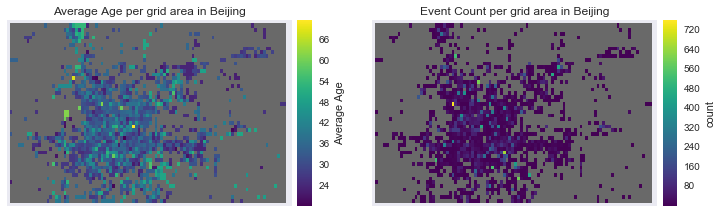

In [24]:
# PLOT BY AGE
plt.figure(5, figsize=(12,6))

# Plot avg age per grid
plt.subplot(121)
m5a = Basemap(projection='merc',
             llcrnrlat=lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=long_min,
             urcrnrlon=long_max,
             lat_ts=35,
             resolution='c')

# Construct a heatmap
longs = df_mean_age.index.values
lats = df_mean_age.columns.values
x, y = np.meshgrid(longs, lats) 
px, py = m5a(x, y) 
data_values = df_mean_age.values
masked_data = np.ma.masked_invalid(data_values.T)
cmap = plt.cm.viridis
cmap.set_bad(color="#696969")

# Plot the heatmap
m5a.pcolormesh(px, py, masked_data, cmap=cmap, zorder=5)
m5a.colorbar().set_label("Average Age")
plt.title("Average Age per grid area in Beijing")

# Plot count per grid
plt.subplot(122)
m5b = Basemap(projection='merc',
             llcrnrlat=lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=long_min,
             urcrnrlon=long_max,
             lat_ts=35,
             resolution='c')

# Construct a heatmap 
data_values = df_cnt_age.values
masked_data = np.ma.masked_invalid(data_values.T)
cmap = plt.cm.viridis
cmap.set_bad(color="#696969")

# Plot the heatmap
m5b.pcolormesh(px, py, masked_data, cmap=cmap, zorder=5)
m5b.colorbar().set_label("count")
plt.title("Event Count per grid area in Beijing")

plt.show()

#### PHONE_BRAND_DEVICE_MODEL TABLE

In [6]:
print('NUMBER OF ROWS:', raw_phone_brand_device_model.shape[0])

print('\nNULL VALUES:')
print(raw_phone_brand_device_model.isnull().sum())

print("\nUNIQUE VALUES:")
for c in raw_phone_brand_device_model.columns:
    print('{}: {}'.format(c, raw_phone_brand_device_model[c].nunique()))

raw_phone_brand_device_model.head(3)

NUMBER OF ROWS: 187245

NULL VALUES:
device_id       0
phone_brand     0
device_model    0
dtype: int64

UNIQUE VALUES:
device_id: 186716
phone_brand: 131
device_model: 1599


,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4


In [7]:
raw_phone_brand_device_model['device_id'].value_counts().sort_values(ascending=False)[:4]

 9218059356897525342    2
 4781989393190512097    2
 5435517613682152801    2
-7525913571507064767    2
Name: device_id, dtype: int64

In [9]:
# Expected device_ids to be unique. Looks like there are duplicates

dupes = raw_phone_brand_device_model.groupby('device_id').size()
dupes = dupes[dupes>1]
print('NUMBER OF DUPLICATES:', dupes.shape[0])

print('\nHOW MANY OF 2N, 3N,... 10N DUPLICATES ARE THERE?:')
dupes.value_counts()

NUMBER OF DUPLICATES: 529

HOW MANY OF 2N, 3N,... 10N DUPLICATES ARE THERE?:


2    529
dtype: int64

In [10]:
# Are these duplicates exactly the same (we can drop them) or are they different?

dupes = raw_phone_brand_device_model.loc[raw_phone_brand_device_model['device_id'].isin(dupes.index)]
firstd = dupes.groupby('device_id').first() # nrows = 529
lastd = dupes.groupby('device_id').last() # nrows = 529

diff = (firstd != lastd).sum(axis=1).nonzero()
pd.concat((firstd.iloc[diff], lastd.iloc[diff]),axis=1)

,phone_brand,device_model,phone_brand,device_model
device_id,,,,
-7297178577997113203,华为,荣耀畅玩5X,华为,荣耀3C
-7059081542575379359,LG,Nexus 5,魅族,魅蓝Note 2
-6590454305031525112,小米,MI 3,华为,荣耀6 Plus
-5269721363279128080,三星,Galaxy Core Advance,小米,MI 3
-3004353610608679970,酷派,5891,酷派,7296
5245428108336915020,魅族,MX4,小米,MI One Plus


In [11]:
# Looks like 6 devices with duplicate rows have different values for brand and model.

# Are they in train or in test?

dev = _.index
print("in train: ",sum(raw_gender_age_train['device_id'].isin(dev)))
print("in test: ",sum(raw_gender_age_test['device_id'].isin(dev)))

in train:  1
in test:  5


In [12]:
# Only 6 rows are weird. Let's just drop all duplicates

phone_brand_device_model = raw_phone_brand_device_model.drop_duplicates('device_id', keep='first')
del raw_phone_brand_device_model

In [13]:
# KAGGLE FORUM POINTS OUT THAT SOME MODEL NAMES CAN BELONG TO DIFFERENT BRANDS!!!

x = phone_brand_device_model.groupby('device_model')['phone_brand'].apply(pd.Series.nunique)
x.value_counts()

1    1545
2      43
3       8
4       3
Name: phone_brand, dtype: int64

In [16]:
# Use the same trick as we would in excel:  encode and concatenate brand and model.

lebrand = LabelEncoder().fit(phone_brand_device_model['phone_brand'])
phone_brand_device_model['ec_brand'] = lebrand.transform(phone_brand_device_model['phone_brand'])
m = phone_brand_device_model['phone_brand'].str.cat(phone_brand_device_model['device_model'])
lemodel = LabelEncoder().fit(m)
phone_brand_device_model['ec_model'] = lemodel.transform(m)

In [18]:
phone_brand_device_model.head()

,device_id,phone_brand,device_model,brand,model
0,-8890648629457979026,小米,红米,51,858
1,1277779817574759137,小米,MI 2,51,843
2,5137427614288105724,三星,Galaxy S4,15,371
3,3669464369358936369,SUGAR,时尚手机,9,166
4,-5019277647504317457,三星,Galaxy Note 2,15,347


#### Brand and model distribution

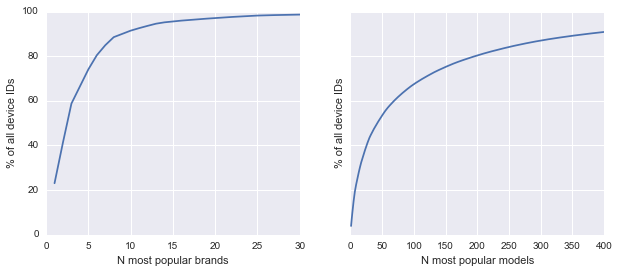

In [22]:
brand_count = phone_brand_device_model['ec_brand'].value_counts()
ss = brand_count.cumsum()/brand_count.sum()
fig, (ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(10,4))
ax1.plot(np.arange(ss.shape[0])+1, ss.values*100)
ax1.set_xlim(0,30)
ax1.set_xlabel('N most popular brands')
ax1.set_ylabel('% of all device IDs');
del brand_count

model_count = phone_brand_device_model['ec_model'].value_counts()
ss = model_count.cumsum()/model_count.sum()
ax2.plot(np.arange(ss.shape[0])+1, ss.values*100)
ax2.set_xlim(0,400)
ax2.set_xlabel('N most popular models')
ax2.set_ylabel('% of all device IDs');

In [25]:
train = raw_gender_age_train.merge(phone_brand_device_model[['device_id','ec_brand','ec_model']], how='left',on='device_id')
train.head()

,device_id,gender,age,group,brand,model
0,-8076087639492063270,M,35,M32-38,51,843
1,-2897161552818060146,M,35,M32-38,51,843
2,-8260683887967679142,M,35,M32-38,51,843
3,-4938849341048082022,M,30,M29-31,51,865
4,245133531816851882,M,30,M29-31,51,847


## Since we are predicting demographics (gender, age), we should plot the data by these dimensions

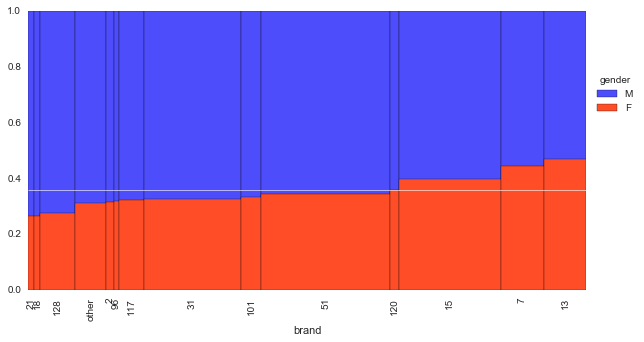

In [31]:
def plot_by(df, cat, by, perc = 0.95):
    
    # Find popular categories
    cc = df[by].value_counts().cumsum()/df.shape[0]
    take = cc[cc<=perc].index
    
    # Pool rare categories into 'other' cat
    gr = df[by].copy()
    gr[~(df[by].isin(take))] = 'other'
    
    # Count target classes in groups
    cc = df.groupby([gr,cat]).size().unstack().fillna(0)
    total = cc.sum(axis=1)
    meanprobs = cc.sum(axis=0).cumsum()/df.shape[0]
    
    # Transform to probabilities
    sortcol = cc.columns[int(np.floor((cc.shape[1]-1)/2))]
    cc = cc.div(cc.sum(axis=1), axis='index')
    
    # Cumsum for stacked bars
    cc = cc.cumsum(axis=1).sort_values(by=sortcol)
    total = total.loc[cc.index]
    
    # Prepare plot data
    left = np.array([0, *(total.iloc[:-1].cumsum().values)])
    ticks = left + 0.5*total.values
    colors = cm.rainbow(np.linspace(0.1,0.9,num=cc.shape[1]))
    fig, ax = plt.subplots(figsize=(10,5))
    for (i,col) in enumerate(cc.columns[::-1]):
        height = cc[col].values
        ax.bar(left, height, total.values,label=col,color=colors[i],zorder = cc.shape[0]+i)
    for p in meanprobs.iloc[:-1]:
        ax.hlines(p, 0, total.sum(),
                  color='w',alpha=0.6,zorder=cc.shape[0]*10,linewidth=1)
    # legend placement needs more work
    ax.legend(bbox_to_anchor=(1.1, 0.8),title=cat)
    ax.set_xticks(ticks)
    ax.set_xticklabels(total.index, rotation='vertical')
    ax.set_xlabel(by)
    ax.set_xlim(0,left[-1]+total.values[-1])
    return ax

ax = plot_by(train, 'gender','brand')

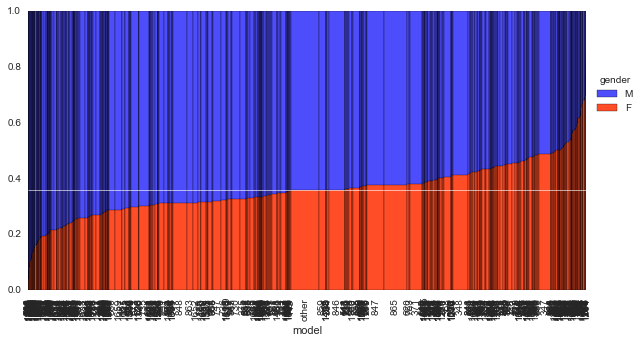

In [32]:
ax = plot_by(train, 'gender','model')

In [33]:
# Too many models.  But some of them could be a good predictor for gender.
# Look at brands preferred by female users
lebrand.classes_[[15, 7, 13]]

array(['三星', 'OPPO', 'vivo'], dtype=object)

#### Now plot by age

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


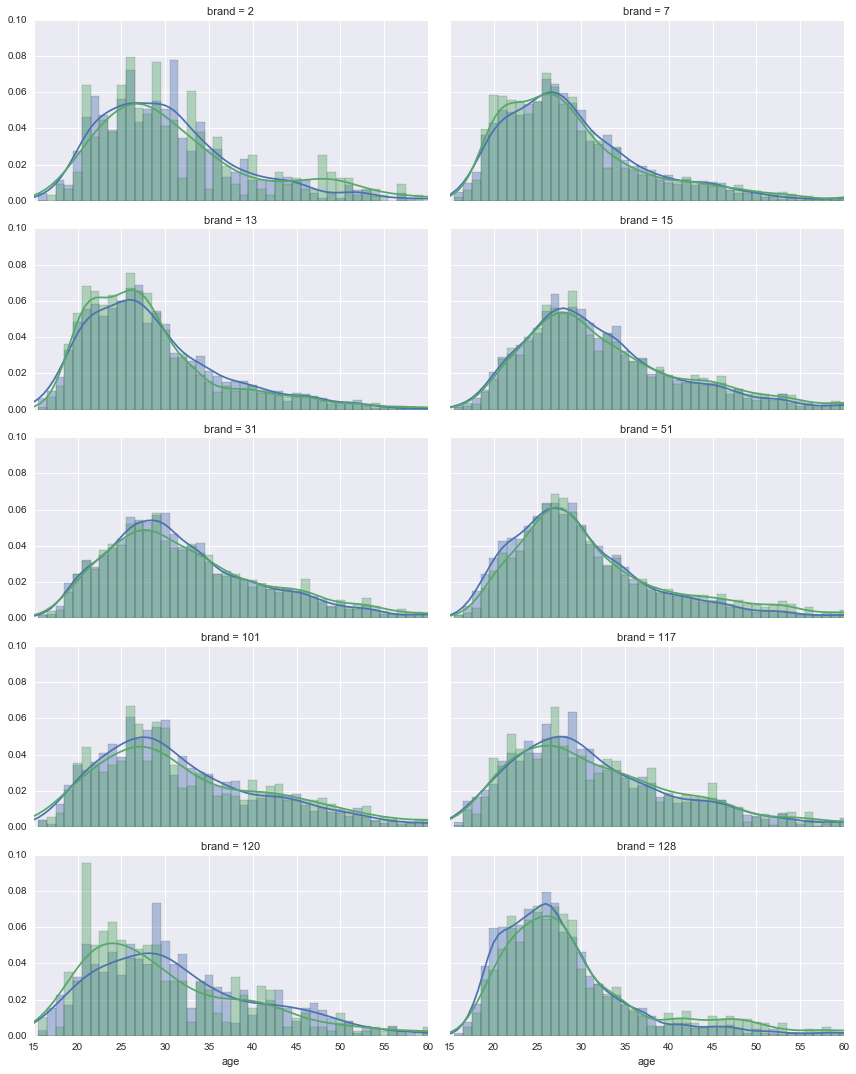

In [36]:
top_brands = train['brand'].value_counts().index[:10]
cc = train[train['brand'].isin(top_brands)]
g = sns.FacetGrid(cc, hue='gender', col='brand',col_wrap=2, aspect=2, xlim=(15,60))
g.map(sns.distplot, 'age', bins=np.arange(15,70)+0.5)

top_models = train['model'].value_counts().index[:10]
c = train[train['model'].isin(top_models)]
g = sns.FacetGrid(c, hue='gender', col='model',col_wrap=2, aspect=2, xlim=(15,60))
g.map(sns.distplot, 'age', bins=np.arange(15,70)+0.5)

## Now let's explore training set

In [45]:
print('NUMBER OF ROWS:', raw_gender_age_train.shape[0])

print('\nNULL VALUES:')
print(raw_gender_age_train.isnull().sum())

print("\nUNIQUE VALUES:")
for c in raw_gender_age_train.columns:
    print('{}: {}'.format(c, raw_gender_age_train[c].nunique()))

raw_gender_age_train.head(3)

NUMBER OF ROWS: 74645

NULL VALUES:
device_id    0
gender       0
age          0
group        0
dtype: int64

UNIQUE VALUES:
device_id: 74645
gender: 2
age: 85
group: 12


,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38


In [46]:
print('NUMBER OF ROWS:', raw_gender_age_test.shape[0])

print('\nNULL VALUES:')
print(raw_gender_age_test.isnull().sum())

print("\nUNIQUE VALUES:")
for c in raw_gender_age_test.columns:
    print('{}: {}'.format(c, raw_gender_age_test[c].nunique()))

raw_gender_age_test.head(3)

NUMBER OF ROWS: 112071

NULL VALUES:
device_id    0
dtype: int64

UNIQUE VALUES:
device_id: 112071


,device_id
0,1002079943728939269
1,-1547860181818787117
2,7374582448058474277


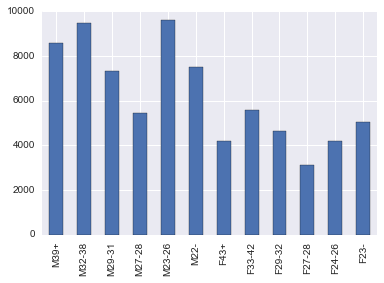

In [48]:
raw_gender_age_train['group'].value_counts().sort_index(ascending=False).plot(kind='bar')

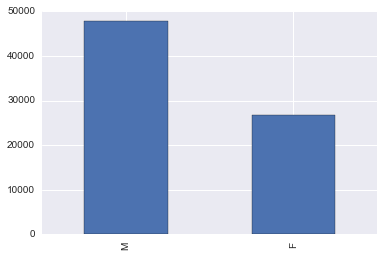

In [49]:
raw_gender_age_train['gender'].value_counts().plot(kind='bar')

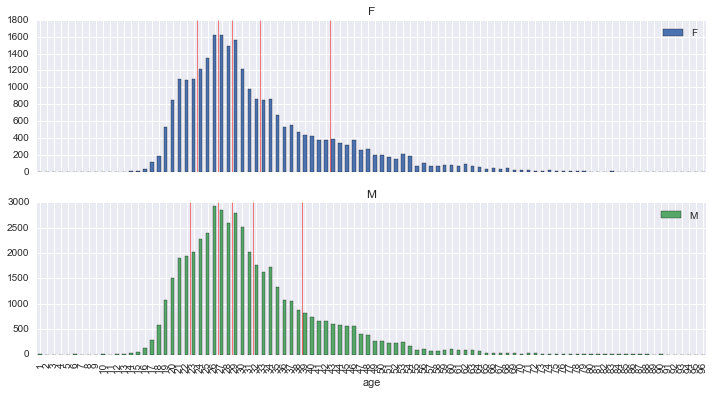

In [51]:
cc = raw_gender_age_train.groupby(['age','gender']).size().unstack().reindex(index=np.arange(raw_gender_age_train['age'].min(), raw_gender_age_train['age'].max()+1)).fillna(0)
ax1, ax2 = cc.plot(kind='bar',figsize=(12,6),subplots=True);
ax1.vlines(np.array([23,26,28,32,42])-0.5,0,1800,alpha=0.5,linewidth=1,color='r')
ax2.vlines(np.array([22,26,28,31,38])-0.5,0,3000,alpha=0.5,linewidth=1,color='r')

In [53]:
# 1/n_classes benchmark

letarget = LabelEncoder().fit(raw_gender_age_train['group'].values)
y = letarget.transform(raw_gender_age_train['group'].values)
n_classes = len(letarget.classes_)

In [57]:
pred = np.ones((raw_gender_age_train.shape[0],n_classes))/n_classes
log_loss(y, pred)

2.4849066497880012

In [58]:
# Naive dumb predictor
# The best we can do without features

kf = KFold(raw_gender_age_train.shape[0], n_folds=10, shuffle=True, random_state=0)
pred = np.zeros((raw_gender_age_train.shape[0],n_classes))
for itrain, itest in kf:
    train = raw_gender_age_train.iloc[itrain,:]
    test = raw_gender_age_train.iloc[itest,:]
    ytrain, ytest = y[itrain], y[itest]
    prob = train.groupby('group').size()/train.shape[0]
    pred[itest,:] = prob.values
print(log_loss(y, pred))

2.42805122275


## Now let's try predicting gender from phone brand

In [39]:
ptrain = raw_gender_age_train.merge(phone_brand_device_model[['device_id','brand','model']], how='left',on='device_id')
ptrain.head(3)

,device_id,gender,age,group,brand,model
0,-8076087639492063270,M,35,M32-38,51,843
1,-2897161552818060146,M,35,M32-38,51,843
2,-8260683887967679142,M,35,M32-38,51,843


In [40]:
class GenderProba(object):
    def __init__(self, prior_weight=10.):
        self.prior_weight = prior_weight
    
    def fit(self, df, by):
        self.by = by
        self.label = 'pF_' + by
        self.prior = (df['gender']=='F').mean()
        
        # fit age groups
        prob = train.groupby(['gender','group']).size()
        prob_F = prob['F']/prob['F'].sum()
        prob_M = prob['M']/prob['M'].sum()
        self.agegroups = pd.concat((prob_F,prob_M),axis=0)
        
        # fit gender probs by grouping column
        c = (df[['gender']]=='F').groupby(df[by]).agg(['sum','count'])
        s = c[('gender','sum')]
        n = c[('gender','count')]
        prob = (s + self.prior*self.prior_weight) / (n + self.prior_weight)
        self.prob = pd.DataFrame(prob, columns=[self.label])
        return self
    
    def predict_proba(self, df):
        pF = df[[self.by]].merge(self.prob, how='left', 
                                left_on=self.by, right_index=True).fillna(self.prior)[self.label]
        pF = np.reshape(pF.values,(pF.shape[0],1))
        pred = np.zeros((df.shape[0],12))
        pred += self.agegroups.values
        pred[:,:6] *= pF
        pred[:,6:] *= 1-pF
        return pred

In [60]:
kf = KFold(ptrain.shape[0], n_folds=10, shuffle=True, random_state=0)
pred = np.zeros((ptrain.shape[0],n_classes))
for itrain, itest in kf:
    train = ptrain.iloc[itrain,:]
    test = ptrain.iloc[itest,:]
    ytrain, ytest = y[itrain], y[itest]
    clf = GenderProba().fit(train,'brand')
    pred[itest,:] = clf.predict_proba(test)
print(log_loss(y, pred))

2.42056997969


In [64]:
# wrap scoring in a function to try different prior_weight values

def score(ptrain, by, prior_weight=10.):
    kf = KFold(ptrain.shape[0], n_folds=10, shuffle=True, random_state=0)
    pred = np.zeros((ptrain.shape[0],n_classes))
    for itrain, itest in kf:
        train = ptrain.iloc[itrain,:]
        test = ptrain.iloc[itest,:]
        ytrain, ytest = y[itrain], y[itest]
        clf = GenderProba(prior_weight=prior_weight).fit(train,by)
        pred[itest,:] = clf.predict_proba(test)
    return log_loss(y, pred)

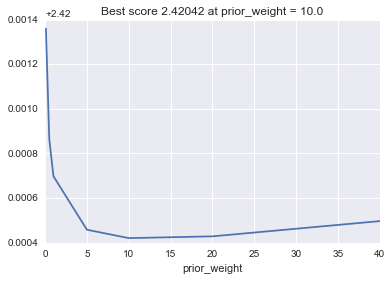

In [65]:
weights = [0.1, 0.5, 1., 5., 10., 20.,40.]
res = [score(ptrain,'brand',prior_weight=w) for w in weights]
plt.plot(weights, res)
plt.title('Best score {:.5f} at prior_weight = {}'.format(np.min(res),weights[np.argmin(res)]))
plt.xlabel('prior_weight')

## Predict gender from device model

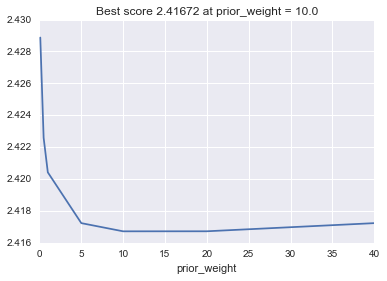

In [66]:
weights = [0.1, 0.5, 1., 5., 10., 20.,40.]
res = [score(ptrain,'model',prior_weight=w) for w in weights]
plt.plot(weights, res)
plt.title('Best score {:.5f} at prior_weight = {}'.format(np.min(res),weights[np.argmin(res)]))
plt.xlabel('prior_weight')

## Predict gender-age group from phone brand

In [68]:
class GenderAgeGroupProb(object):
    def __init__(self, prior_weight=10.):
        self.prior_weight = prior_weight
    
    def fit(self, df, by):
        self.by = by
        #self.label = 'pF_' + by
        self.prior = df['group'].value_counts().sort_index()/df.shape[0]
        # fit gender probs by grouping column
        c = df.groupby([by, 'group']).size().unstack().fillna(0)
        total = c.sum(axis=1)
        self.prob = (c.add(self.prior_weight*self.prior)).div(c.sum(axis=1)+self.prior_weight, axis=0)
        return self
    
    def predict_proba(self, df):
        pred = df[[self.by]].merge(self.prob, how='left', 
                                left_on=self.by, right_index=True).fillna(self.prior)[self.prob.columns]
        pred.loc[pred.iloc[:,0].isnull(),:] = self.prior
        return pred.values
    
def score(ptrain, by, prior_weight=10.):
    kf = KFold(ptrain.shape[0], n_folds=10, shuffle=True, random_state=0)
    pred = np.zeros((ptrain.shape[0],n_classes))
    for itrain, itest in kf:
        train = ptrain.iloc[itrain,:]
        test = ptrain.iloc[itest,:]
        ytrain, ytest = y[itrain], y[itest]
        clf = GenderAgeGroupProb(prior_weight=prior_weight).fit(train,by)
        pred[itest,:] = clf.predict_proba(test)
    return log_loss(y, pred)

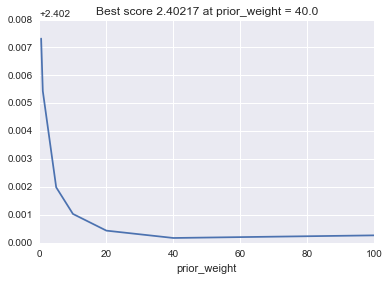

In [69]:
weights = [0.5, 1., 5., 10., 20.,40.,100.]
res = [score(ptrain,'brand',prior_weight=w) for w in weights]
plt.plot(weights, res)
plt.title('Best score {:.5f} at prior_weight = {}'.format(np.min(res),weights[np.argmin(res)]))
plt.xlabel('prior_weight')

## Predict gender-age group from device model

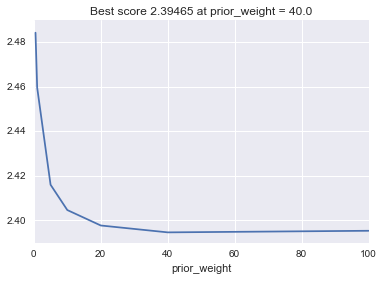

In [70]:
weights = [0.5, 1., 5., 10., 20.,40.,100.]
res = [score(ptrain,'model',prior_weight=w) for w in weights]
plt.plot(weights, res)
plt.title('Best score {:.5f} at prior_weight = {}'.format(np.min(res),weights[np.argmin(res)]))
plt.xlabel('prior_weight')

## predict gender-age group from both: brand and device model

In [71]:
kf = KFold(ptrain.shape[0], n_folds=10, shuffle=True, random_state=0)
predb = np.zeros((ptrain.shape[0],n_classes))
predm = np.zeros((ptrain.shape[0],n_classes))
for itrain, itest in kf:
    train = ptrain.iloc[itrain,:]
    test = ptrain.iloc[itest,:]
    ytrain, ytest = y[itrain], y[itest]
    clf = GenderAgeGroupProb(prior_weight=40.).fit(train,'brand')
    predb[itest,:] = clf.predict_proba(test)
    clf = GenderAgeGroupProb(prior_weight=40.).fit(train,'model')
    predm[itest,:] = clf.predict_proba(test)
log_loss(y, 0.5*(predb+predm))

2.3909032414810976

In [72]:
#that's the smallest log_loss yet